# Model-based filtering of matches - RANSAC

In this recipe, you will learn how to robustly filter matches between keypoints in two images using the **Random Sample Consensus (RANSAC)** algorithm under the assumption that there's a homography transformation between the two images. This technique helps filter out bad matches and only leaves the ones that satisfy the motion model between two images.

In this recipe, we estimate homography model parameters between two images using the robust **RANSAC** algorithm. It's done through the `cv2.findHomography` function with the `cv2.RANSAC` parameter. The function returns a homography transformation estimated by point correspondences as well as the inliers mask. The inlier mask deals with correspondences that satisfy the estimated motion model with a low enough error. In our case, the error is computed as a Euclidean distance between the matched point and the corresponding point transformed according to the motion model.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


------  data/Lena.png------------    Shape(512, 512, 3) img_orig: uint8
[[120  71 130] [ 97  43 121] [ 93  42 118] [106  64 151] [125 100 181] [120  75 160] [117  65 145] ]
[[ 86  35 108] [ 92  39 114] [119  65 140] [115  70 149] [127  84 159] [115  68 145] [107  56 134] ]
[[ 92  40 110] [106  57 129] [137  81 154] [122  80 151] [136  88 151] [121  73 137] [ 86  35 110] ]
[[105  52 124] [140  87 152] [147 101 163] [127  78 148] [137  81 144] [ 95  43 114] [ 83  31 105] ]
[[139  86 153] [154 113 169] [147 104 167] [129  81 147] [101  53 125] [ 93  37 106] [113  63 122] ]
------  image_rotated------------    Shape(512, 512, 3) image_rotated: uint8
[[103  45 117] [ 89  36 104] [ 95  42 106] [117  57 119] [117  58 117] [109  50 112] [106  48 113] ]
[[110  54 122] [ 90  39 104] [ 88  41 102] [109  52 113] [119  57 120] [101  45 111] [109  48 113] ]
[[117  65 126] [ 94  45 111] [ 86  42 105] [101  45 106] [110  52 116] [ 95  42 110] [113  49 115] ]
[[110  63 125] [ 98  51 117] [ 93  45 107] 

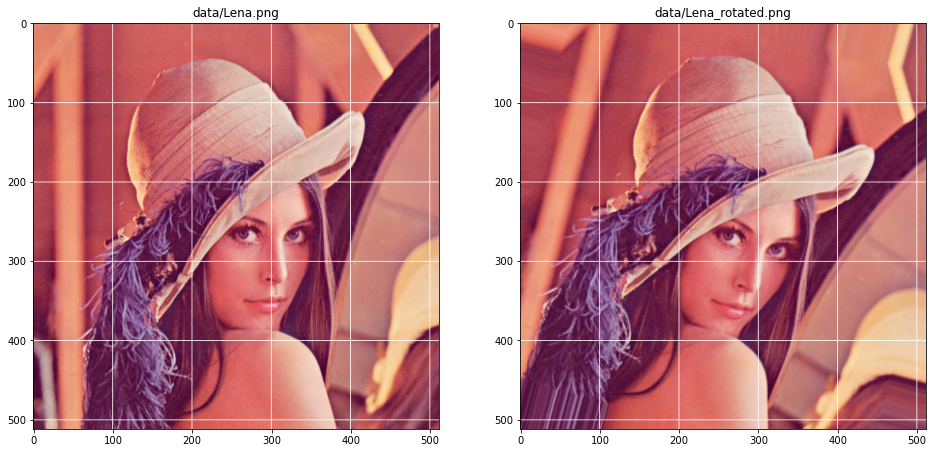

In [2]:
image_orig = cv2.imread('../data/Lena.png')

M = np.array([[math.cos(np.pi/12), -math.sin(np.pi/12), 0],
             [math.sin(np.pi/12), math.cos(np.pi/12), 0],
             [0,0,1]])
Moff = np.eye(3)
Moff[0,2] = -image_orig.shape[1]/2
Moff[1,2] = -image_orig.shape[0]/2
image_rotated = cv2.warpPerspective(image_orig, np.linalg.inv(Moff)@M@Moff,
                    (image_orig.shape[1], image_orig.shape[0]), borderMode=cv2.BORDER_REPLICATE)



######################################
print_image('data/Lena.png','img_orig',image_orig,300,305,100,107)
print_image('image_rotated','image_rotated',image_rotated,300,305,100,107)
plt_view_image(plt,[["data/Lena.png", draw_grid(np.copy(image_orig),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/Lena_rotated.png",
                     draw_grid(np.copy(image_rotated),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

------  image_gray---------------    Shape(512, 512) image_gray: uint8
[ 94 72 71 95 127 106 95 74 71 74 92 108 119 107 79 59 47 43 53 59 86 81 103 155 130 93 89 ]
[ 63 67 94 99 111 96 85 69 74 100 114 128 108 70 54 54 52 58 56 57 60 53 88 138 142 108 92 ]
[ 67 84 109 106 112 98 63 70 93 115 133 108 76 58 57 57 64 56 67 50 56 51 71 114 144 123 94 ]
[ 80 112 125 105 106 70 59 94 127 124 94 59 58 55 57 73 78 56 82 53 51 51 64 94 137 126 107 ]
[ 112 134 128 106 80 64 86 131 136 88 60 52 54 55 60 102 74 62 86 73 62 55 77 114 141 130 116 ]
------  img0---------------------    Shape(512, 512) img0: uint8
[ 99 82 80 103 133 114 103 82 80 82 98 112 122 110 84 66 59 56 64 68 93 85 106 156 133 98 93 ]
[ 72 76 101 106 117 103 93 78 82 105 118 130 111 76 61 61 61 64 66 66 68 61 92 139 144 114 98 ]
[ 74 92 115 112 117 102 72 78 99 118 134 111 82 66 64 64 72 66 74 61 64 61 76 116 144 126 99 ]
[ 87 117 128 110 111 78 68 99 130 126 98 68 68 64 66 78 84 64 87 64 59 61 72 98 138 128 112 ]
[ 117 138 131 

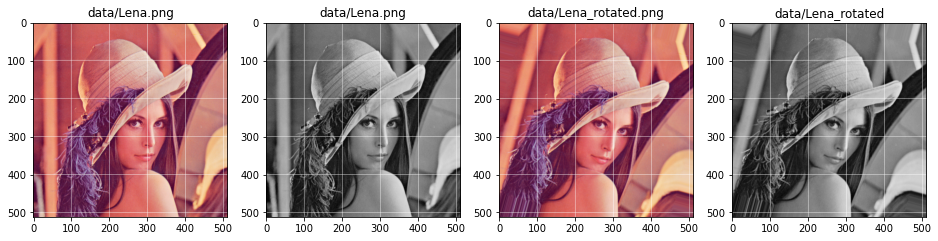

In [3]:
image_grey = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
image_grey_rotated = cv2.cvtColor(image_rotated, cv2.COLOR_BGR2GRAY)
img0 = cv2.imread('../data/Lena.png', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('../data/Lena_rotated.png', cv2.IMREAD_GRAYSCALE)



###################################################
print_image('image_gray','image_gray',image_grey,300,305,100,127)
print_image('img0','img0',img0,300,305,100,127)
print_image('image_gray_rotated','image_gray_rotated',image_grey_rotated,300,305,100,127)
print_image('img1','img1',img1,300,305,100,127)

plt_view_image(plt,[["data/Lena.png", draw_grid(np.copy(image_orig),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/Lena.png", draw_grid(np.copy(image_grey),100,(255,255,255))],
                    ["data/Lena_rotated.png",
                     draw_grid(np.copy(image_rotated),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/Lena_rotated", draw_grid(np.copy(image_grey_rotated),100,(255,255,255))]
                   ],
               figsize=(16,4), axis='on', cmap='gray')

Detect the keypoints and computer descriptors:

In [4]:
detector = cv2.ORB_create(100)
kps_orig,    fea0 = detector.detectAndCompute(image_grey, None)
kps_rotated, fea1 = detector.detectAndCompute(image_grey_rotated, None)
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, False)
matches = matcher.match(fea0, fea1)

Fit the homography model into the found keypoint correspondences robustly and get a mask of inlier matches:

In [5]:
pts0 = np.float32([kps_orig[m.queryIdx].pt    for m in matches]).reshape(-1,2)
pts1 = np.float32([kps_rotated[m.trainIdx].pt for m in matches]).reshape(-1,2)
H, mask = cv2.findHomography(pts0, pts1, cv2.RANSAC, 3.0)

In [6]:
image_ORB = draw_grid(np.copy(image_orig),100,(255,255,255))
for p in cv2.KeyPoint_convert(kps_orig):
    cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)
image_Keypoints_orig = cv2.drawKeypoints(draw_grid(np.copy(image_orig),100,(255,255,255)), 
                                        kps_orig, None, (0,255, 255))    


img_Rotated = draw_grid(np.copy(image_rotated),100,(255,255,255))
for p in cv2.KeyPoint_convert(kps_rotated):
    cv2.circle(img_Rotated, tuple(p), 4, (0, 255, 255), cv2.FILLED)

image_Keypoints_rotd = cv2.drawKeypoints(draw_grid(np.copy(img_Rotated),100,(255,255,255)), 
                                        kps_rotated, None, (0,255, 255))

<ipython-input-6-a405b45311fb>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image_ORB, tuple(p), 4, (0, 255, 255), cv2.FILLED)
<ipython-input-6-a405b45311fb>:10: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_Rotated, tuple(p), 4, (0, 255, 255), cv2.FILLED)


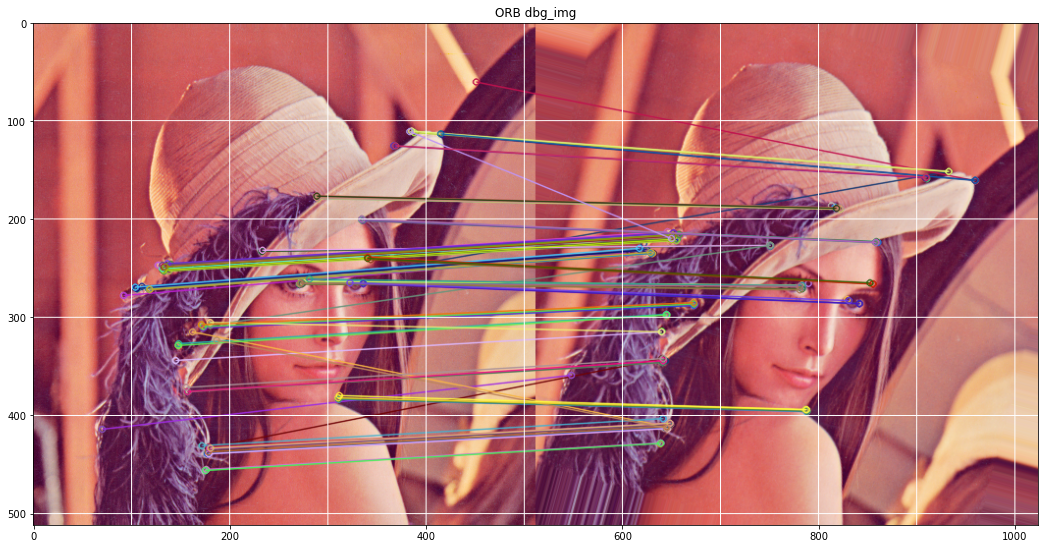

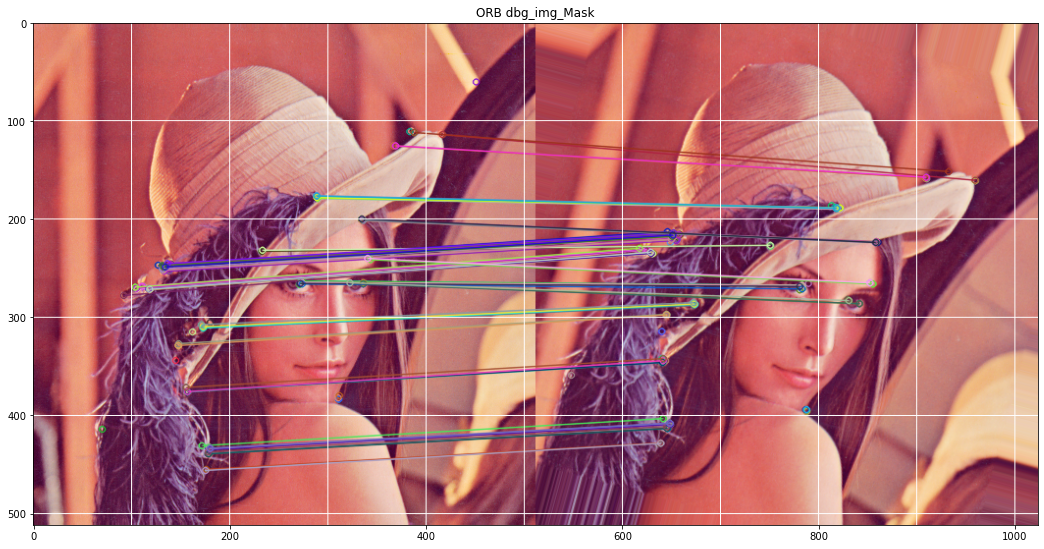

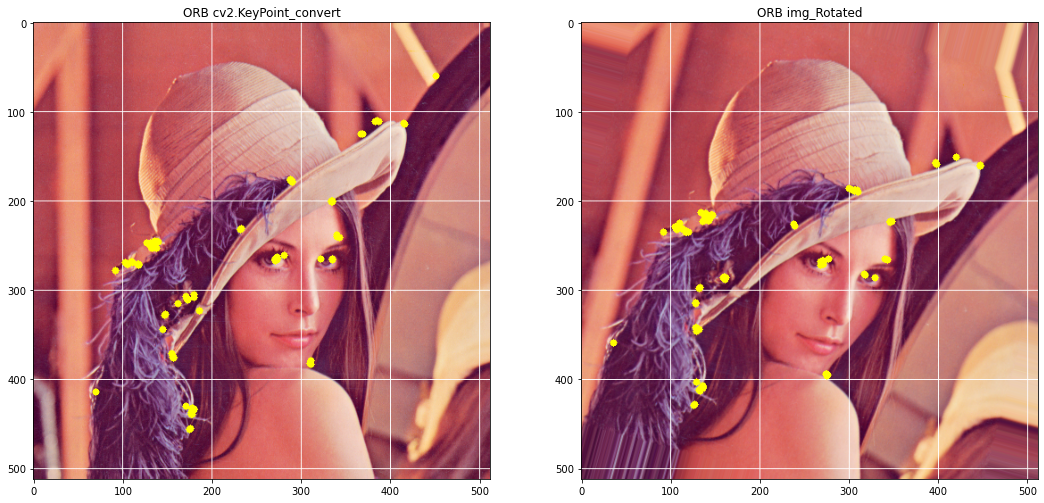

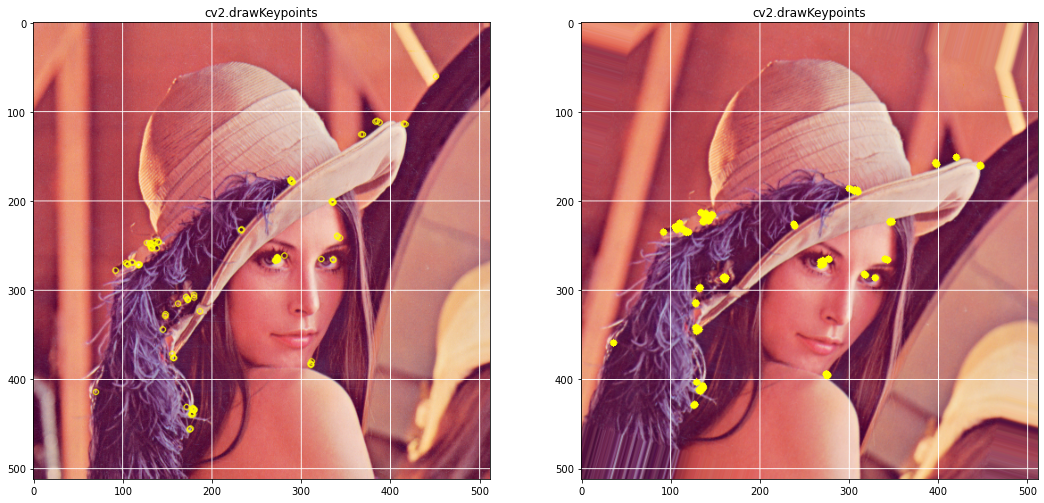

In [7]:
dbg_img =      cv2.drawMatches(image_orig, kps_orig, image_rotated, kps_rotated, matches, None)
dbg_img_Mask = cv2.drawMatches(image_orig, kps_orig, image_rotated, kps_rotated, 
                               [m for i,m in enumerate(matches) if mask[i]], None)


#########################################################################
plt_view_image(plt,[["ORB dbg_img",draw_grid(np.copy(dbg_img),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')
plt_view_image(plt,[["ORB dbg_img_Mask",draw_grid(np.copy(dbg_img_Mask),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')


plt_view_image(plt,[["ORB cv2.KeyPoint_convert",image_ORB[:,:,[2,1,0]]],
                    ["ORB img_Rotated",img_Rotated[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')
plt_view_image(plt,[["cv2.drawKeypoints", image_Keypoints_orig[:,:,[2,1,0]]],
                    ["cv2.drawKeypoints", image_Keypoints_rotd[:,:,[2,1,0]]]],
               figsize=(18,10), axis='on', cmap='gray')